##### IMPORTS

In [7]:
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures



# Projekt zur Altersvorhersage von Abalones

## Einführung




Die traditionelle Altersbestimmung von Abalonen, basierend auf dem manuellen Zählen der Wachstumsringe auf der Schale, stellt ein invasives und arbeitsintensives Verfahren dar. In unserem Projekt haben wir dieses Vorgehen durch ein innovatives maschinelles Lernmodell ersetzt, das das Alter der Abalonen anhand verschiedener physischer Merkmale präzise vorhersagt. Der genutzte Abalone-Datensatz, der vom UCI Machine Learning Repository[^1] bezogen wurde, beinhaltet eine Vielzahl von Merkmalen, darunter Größe (Länge, Durchmesser, Höhe) sowie verschiedene Gewichtskomponenten (Gesamtgewicht, Fleischgewicht, Eingeweidegewicht und Schalengewicht). Zusätzlich wurde das Geschlecht der Abalonen durch One-Hot-Encoding in eine für maschinelles Lernen verarbeitbare Form transformiert.

Die sorgfältige Vorverarbeitung des Datensatzes führte zu einer robusten Datenbasis von 4.177 Einträgen ohne fehlende Werte, die als Grundlage für unsere Regressionsanalysen diente. Das primäre Ziel unserer umfassenden Analyse war die Vorhersage des Alters der Abalonen, ausgedrückt durch die Anzahl der Wachstumsringe, was in der Biologie als Indikator für das Alter gilt. Dieser Ansatz verspricht nicht nur eine Reduzierung des Arbeitsaufwandes, sondern auch eine Verbesserung der Wohlfahrt der Tiere, da das invasive Zählen der Ringe entfällt.


[^1]: https://archive.ics.uci.edu/dataset/1/abalone


## Datenaufbereitung und -analyse





### Daten laden: Einlesen des Abalone-Datensatzes und Überprüfung der Grundstruktur.

In [8]:
df = pd.read_csv('../data/abalone.csv')
df.head()


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### Deskriptive Statistiken: Ermittlung zusammenfassender Statistiken zur Datenverteilung.


In [9]:
print('Descriptive statistics')
print()
print(df.describe())
print()

Descriptive statistics

            Length     Diameter       Height  Whole weight  Shucked weight  \
count  4177.000000  4177.000000  4177.000000   4177.000000     4177.000000   
mean      0.523992     0.407881     0.139516      0.828742        0.359367   
std       0.120093     0.099240     0.041827      0.490389        0.221963   
min       0.075000     0.055000     0.000000      0.002000        0.001000   
25%       0.450000     0.350000     0.115000      0.441500        0.186000   
50%       0.545000     0.425000     0.140000      0.799500        0.336000   
75%       0.615000     0.480000     0.165000      1.153000        0.502000   
max       0.815000     0.650000     1.130000      2.825500        1.488000   

       Viscera weight  Shell weight        Rings  
count     4177.000000   4177.000000  4177.000000  
mean         0.180594      0.238831     9.933684  
std          0.109614      0.139203     3.224169  
min          0.000500      0.001500     1.000000  
25%          0.093

### Prüfung der Datenqualität: Überprüfung auf fehlende Werte und Duplikate.


In [10]:
## Checking for Missing Values
missing_values = df.isnull().sum()
print("Missing values in each feature:\n", missing_values)

print()

## Checking for Duplicates
print("Number of duplicates in the dataset:", df.duplicated().sum())

Missing values in each feature:
 Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

Number of duplicates in the dataset: 0


### Verteilungsanalyse: Untersuchung der Verteilungen kategorischer und numerischer Merkmale.


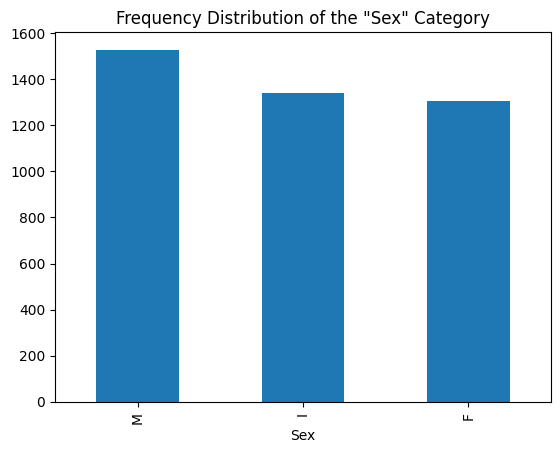

Frequency of Values in the "Sex" Column
Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64


In [11]:
## Frequency Distribution of the "Sex" Category
df['Sex'].value_counts().plot(kind='bar')
plt.title('Frequency Distribution of the "Sex" Category')
plt.show()

## Filtering Data without the "Sex" Column
numeric_features = df.drop(columns=['Sex'])

print('Frequency of Values in the "Sex" Column')
print(df['Sex'].value_counts())


Die Verteilung zeigt eine relativ gleichmäßige Aufteilung zwischen den Geschlechtern, wobei keine Kategorie übermäßig dominiert

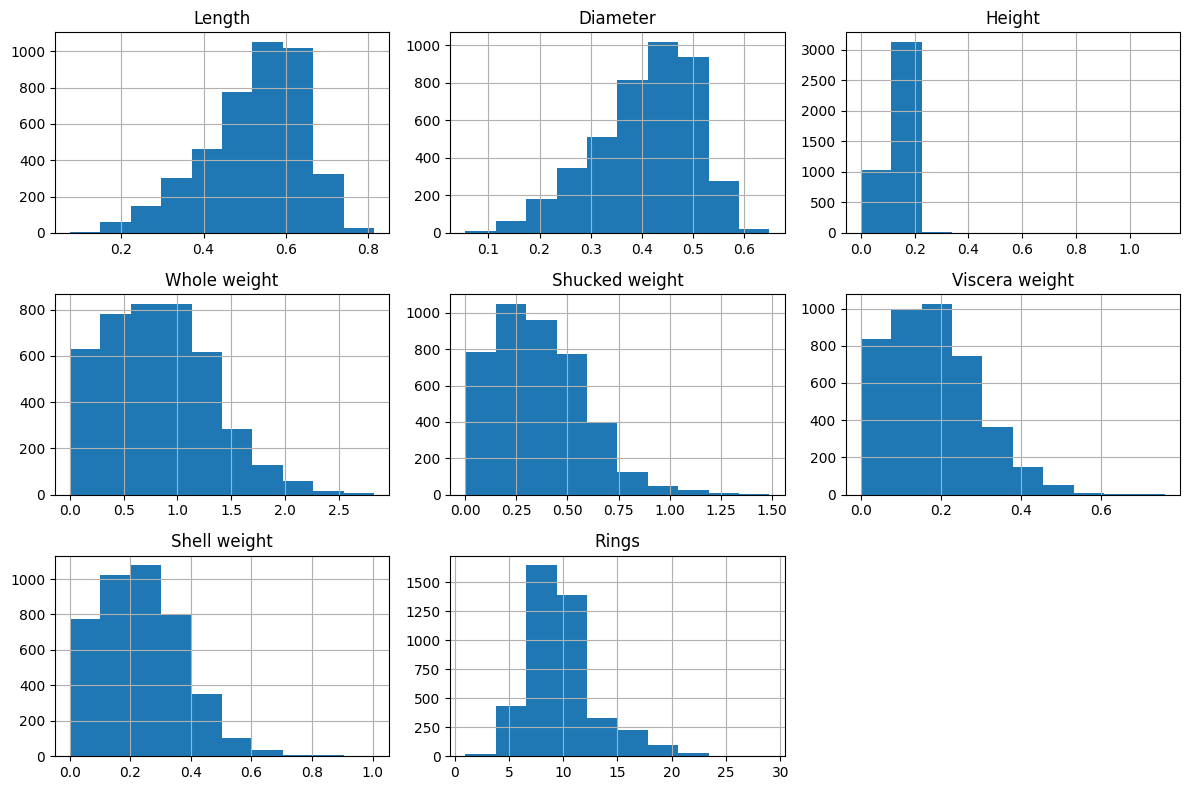

In [12]:
## Visualization of the Distribution for Numeric Features
numeric_features.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()


Die Histogramme der numerischen Merkmale zeigen eine Vielzahl von Verteilungen, die auf unterschiedliche Charakteristika der Daten hinweisen. Einige Merkmale, wie beispielsweise die Länge und der Durchmesser, zeigen eine fast normalverteilte Tendenz, wohingegen andere, wie das Gesamtgewicht, eine rechtsschiefe Verteilung aufweisen, was bedeutet, dass die meisten Abalones ein geringeres Gewicht haben und nur wenige Individuen sehr schwer sind.


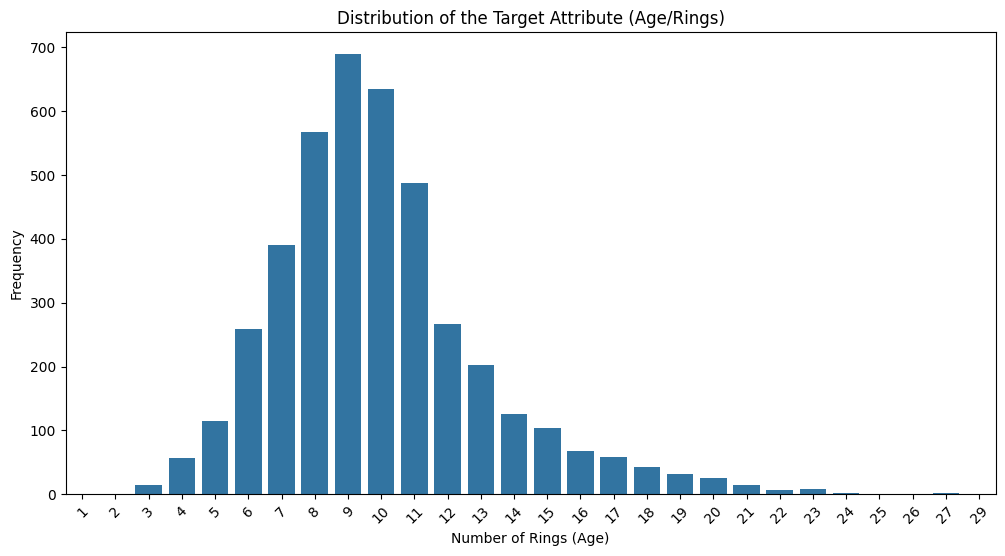

In [13]:

## Distribution of the Target Attribute (Age/Rings)
plt.figure(figsize=(12, 6))
sns.countplot(x='Rings', data=df)
plt.title('Distribution of the Target Attribute (Age/Rings)')
plt.xlabel('Number of Rings (Age)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


Beim Blick auf das Zielattribut "Anzahl der Ringe" im zweiten Bild wird ersichtlich, dass die meisten Abalones eine mittlere Anzahl an Ringen aufweisen, was auf eine mittlere Altersgruppe hindeutet. Es gibt weniger junge und alte Abalones, was in der abfallenden Häufigkeit bei sehr niedrigen und sehr hohen Ringzahlen deutlich wird. Dies könnte bei der Modellierung berücksichtigt werden, da es möglicherweise zu einer Verzerrung führen kann, wenn das Modell mehr Daten in der mittleren Altersgruppe hat und daher dort möglicherweise genauer vorhersagt.

### Korrelationsanalyse: Erstellung einer Heatmap zur Visualisierung der Beziehungen zwischen den Merkmalen.

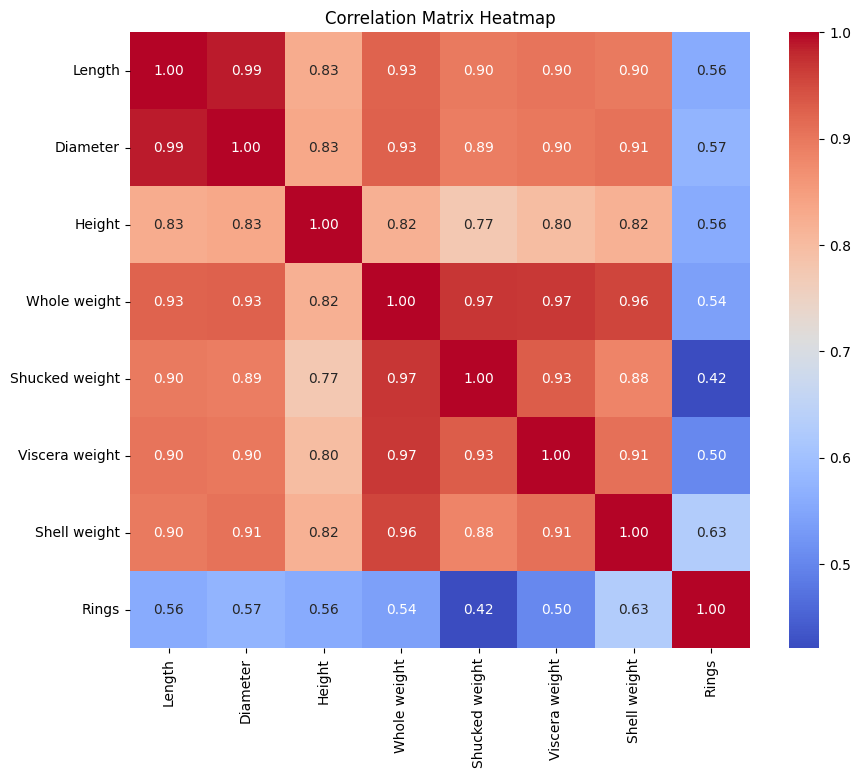

Sex              -0.351822
Length            0.556720
Diameter          0.574660
Height            0.557467
Whole weight      0.540390
Shucked weight    0.420884
Viscera weight    0.503819
Shell weight      0.627574
Rings             1.000000
Name: Rings, dtype: float64


In [14]:
#The categorical feature 'Sex' is first transformed into a set of binary variables to make it usable
df['Sex'] = df['Sex'].map({"M":0, "F":1, "I":2})
print("")

## Correlation Matrix
corr_matrix = numeric_features.corr()

## Correlation Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

corr_matrix = df.corr(method='pearson')
print(corr_matrix['Rings'])



Die Korrelationsmatrix-Heatmap zeigt, dass das Schalengewicht (Shell weight) mit einem Wert von etwa 0,63 die stärkste positive Korrelation zum Alter der Abalones (gemessen an den Ringen) aufweist. Andere Merkmale wie Länge und Durchmesser weisen ebenfalls positive Korrelationen auf, während das Geschlecht eine leichte negative Korrelation zeigt. Diese Informationen sind nützlich, um zu entscheiden, welche Merkmale in Vorhersagemodellen berücksichtigt werden sollten.

### Ausreißererkennung: Identifikation von Ausreißern mit der IQR-Methode.



Displaying Outliers
Sex                 0
Length             49
Diameter           59
Height             29
Whole weight       30
Shucked weight     48
Viscera weight     26
Shell weight       35
Rings             278
dtype: int64


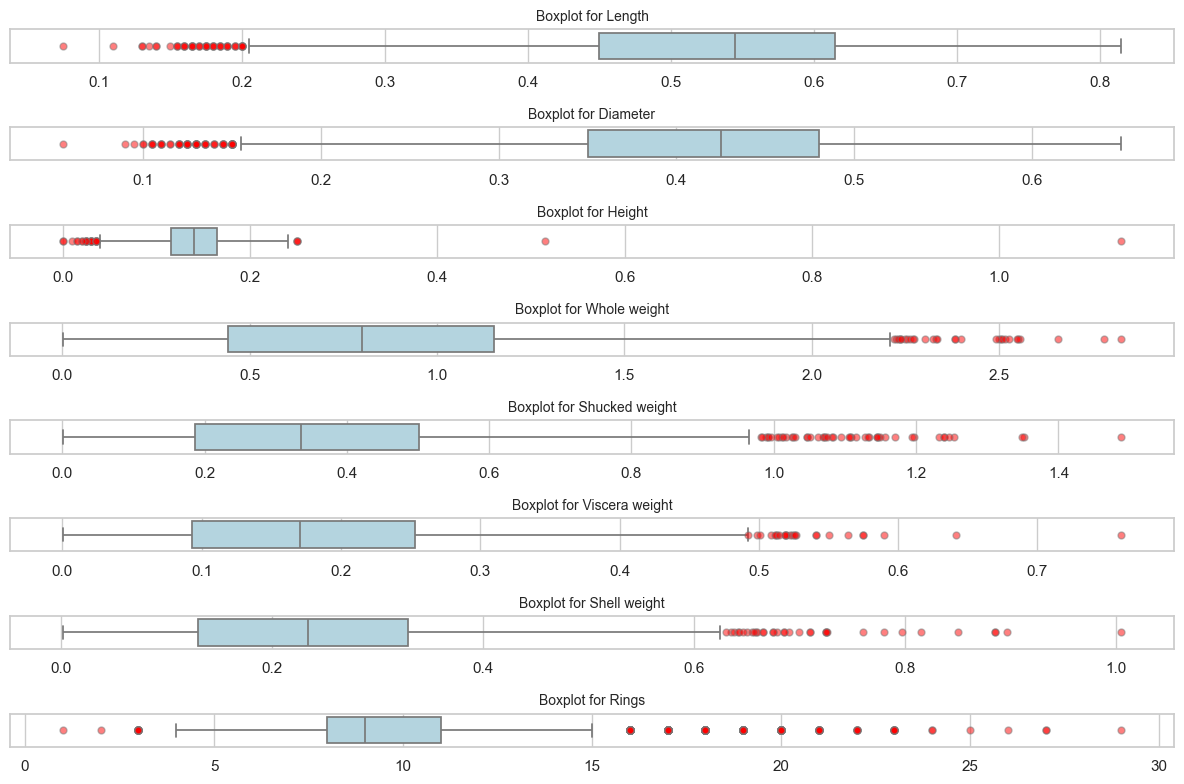

In [15]:
df['Sex'] = df['Sex'].map({"M":0, "F":1, "I":2})
print("")

## Calculation of the first (Q1) and third quartile (Q3) of the dataset
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
## Calculation of the Interquartile Range (IQR), which represents the range of the middle 50% of the data
IQR = Q3 - Q1

## Identification and counting of outliers in each feature of the dataset
## Outliers are defined here as values that are more than 1.5 * IQR below Q1 or above Q3
print("Displaying Outliers")
print(((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum())

sns.set(style="whitegrid")  # Sets a clean background style

## Filtering data without the 'Sex' column
numeric_features = df.drop(columns=['Sex'])

## Determine the number of numeric features
num_cols = numeric_features.shape[1]

## Create a figure and axes for the subplots
fig, axes = plt.subplots(num_cols, 1, figsize=(12, 8))

## Iterate over the numeric features and create individual boxplots
for i, col in enumerate(numeric_features.columns):
    sns.boxplot(x=col, data=numeric_features, ax=axes[i], fliersize=5, color="lightblue", 
                linewidth=1.25, flierprops=dict(marker='o', markersize=5, markerfacecolor='red', alpha=0.5))
    axes[i].set_title(f'Boxplot for {col}', fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()


In der Grafik werden Boxplots für verschiedene numerische Merkmale des Abalone-Datensatzes dargestellt. Die Boxplots zeigen die Verteilungen und helfen, Ausreißer zu identifizieren, die als Punkte dargestellt werden, die außerhalb des durch die Interquartilsabstände (die Länge der Boxen) definierten Bereichs liegen. Merkmale wie Länge, Durchmesser und Schalengewicht weisen relativ wenige Ausreißer auf, während das Merkmal 'Rings', das das Alter darstellt, deutlich mehr Ausreißer zeigt. Dies könnte auf eine breitere natürliche Variation im Alter der Abalones hinweisen oder Bereiche markieren, in denen die Daten möglicherweise fehlerhaft sind oder besondere Phänomene abbilden

## Feature Engineering und Datensatzteilung


### Ermittlung der Merkmalsrelevanz:


Zur Identifizierung der einflussreichsten Features für die Altersvorhersage der Abalonen, wurde ein Random Forest Regressor trainiert. Dieser ermöglichte es, ein Feature-Ranking auf Basis ihrer Wichtigkeiten zu erstellen. 

Feature Ranking:
1. feature Shell weight (0.5017473186542857)
2. feature Shucked weight (0.17132233125551588)
3. feature Whole weight (0.08791613809281446)
4. feature Viscera weight (0.07516304448765047)
5. feature Diameter (0.056040584822695326)
6. feature Length (0.05391023557955155)
7. feature Height (0.05390034710748663)
8. feature Sex (0.0)


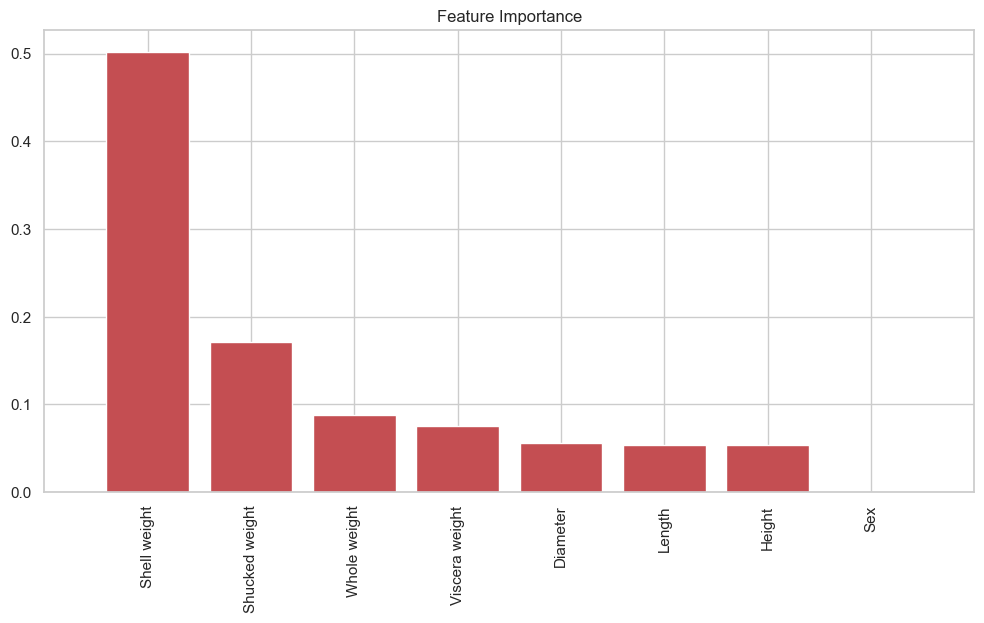

In [16]:
# Assuming 'Rings' is the target attribute we want to predict
X = df.drop('Rings', axis=1)  # All other features
y = df['Rings']               # Target attribute

# Initialization of the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the Random Forest Regressor
rf.fit(X, y)

# Output of feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature importances
print("Feature Ranking:")

for f in range(X.shape[1]):
    print(f"{f + 1}. feature {X.columns[indices[f]]} ({importances[indices[f]]})")
# Visualization of feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


Die Analyse zeigt, dass das Merkmal 'Shell weight' den größten Einfluss hat, gefolgt von 'Shucked weight' und 'Whole weight'. Weitere Merkmale wie 'Viscera weight', 'Diameter', 'Height', 'Length' und 'Sex' haben einen geringeren Vorhersagewert. Die Visualisierung der Feature-Wichtigkeiten liefert wertvolle Einsichten für das Modell-Feintuning und die Feature-Auswahl.



### Datensatzteilung: 
Aufteilung des Datensatzes in Trainings- und Testsets mit einer Verteilung von 70% zu 30% und Speicherung für die spätere Verwendung.

In [17]:
#One-Hot Encoding for the 'Sex' feature
encoder = OneHotEncoder(sparse_output=False)
sex_encoded = encoder.fit_transform(df[['Sex']])  # Transforms 'Sex' into One-Hot encoded features

#Creating a DataFrame from the One-Hot encoded features
sex_encoded_df = pd.DataFrame(sex_encoded, columns=encoder.get_feature_names_out(['Sex']))

#Removing the original 'Sex' column and adding the One-Hot encoded columns
df_encoded = df.drop('Sex', axis=1)
df_encoded = pd.concat([df_encoded, sex_encoded_df], axis=1)

#Defining the target variable and features
X = df_encoded.drop('Rings', axis=1)  # All other features without 'Rings'
y = df_encoded['Rings']               # Target attribute

#Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

#Saving the datasets as CSV files
X_train.to_csv("../data/abalone_train.csv", index=False)
X_test.to_csv("../data/abalone_test.csv", index=False)
y_train.to_csv("../data/abalone_y_train.csv", index=False)
y_test.to_csv("../data/abalone_y_test.csv", index=False)

# Displaying the sizes of the training and test sets
print(f"Size of the training set (Features): {X_train.shape}")
print(f"Size of the test set (Features): {X_test.shape}")
print(f"Size of the training set (Target variable): {y_train.shape}")
print(f"Size of the test set (Target variable): {y_test.shape}")


Size of the training set (Features): (2923, 8)
Size of the test set (Features): (1254, 8)
Size of the training set (Target variable): (2923,)
Size of the test set (Target variable): (1254,)



## Modellierung und Evaluation


### Lineare Regression: Einführung der linearen Regression mit dem RMSE als Evaluationsmetrik.


Ein lineares Regressionsmodell bietet sich hier an, wenn ein vermuteter linearer Zusammenhang zwischen den unabhängigen Variablen (hier das 'Shell weight') und der abhängigen Variable (hier 'Rings' als Indikator für das Alter) besteht. Es ist ein einfacher, leicht interpretierbarer Ansatz, der bei angemessenen Daten gute Vorhersagen liefern kann. Im vorliegenden Beispiel wurde dieses Modell gewählt, weil angenommen wird, dass das Gewicht der Schale ein guter Prädiktor für das Alter ist, wobei ein zunehmendes Gewicht auf ein höheres Alter hindeutet – eine Beziehung, die sich gut mit einem linearen Modell abbilden lässt.

In [18]:
# Function to train the linear model and make predictions
def linear_fit(X, y):
    regressor = LinearRegression()
    regressor.fit(X, y)
    y_pred = regressor.predict(X)
    return y_pred, regressor

# Training the model and calculating predictions for the training set
y_pred_train, model = linear_fit(X_train[['Shell weight']], y_train)

# Calculating predictions for the test set
y_pred_test, _ = linear_fit(X_test[['Shell weight']], y_test)

Die RMSE-Metrik (Root Mean Squared Error), wurde ausgewählt, weil sie ein Maß für die Qualität der Vorhersagen eines Regressionsmodells ist, das sowohl die Varianz als auch die Verzerrung berücksichtigt. RMSE ist die Quadratwurzel des Durchschnitts der quadrierten Differenzen zwischen vorhergesagten und tatsächlichen Werten. Das bedeutet, größere Fehler haben einen überproportional großen Einfluss auf das Gesamtergebnis. Dadurch ist RMSE besonders aussagekräftig bei der Bewertung der Vorhersagegenauigkeit und hilfreich, um zu verstehen, wie gut das Modell mit neuen Daten umgehen kann, was bei der Altersvorhersage von Abalones von großer Bedeutung ist.

In [19]:
# Calculating RMSE
error_train = sqrt(mean_squared_error(y_train, y_pred_train))
error_test = sqrt(mean_squared_error(y_test, y_pred_test))
print("RMSE Error for Linear Regression, Train data is: %.2f" % error_train)
print("RMSE Error for Linear Regression, Test data is: %.2f" % error_test)

RMSE Error for Linear Regression, Train data is: 2.53
RMSE Error for Linear Regression, Test data is: 2.47



Das Modell der linearen Regression zeigt mit einem RMSE von 2.53 auf den Trainingsdaten und 2.47 auf den Testdaten eine konsistente Vorhersageleistung mit einer durchschnittlichen Abweichung von etwa 2,5 Ringen von den tatsächlichen Werten.

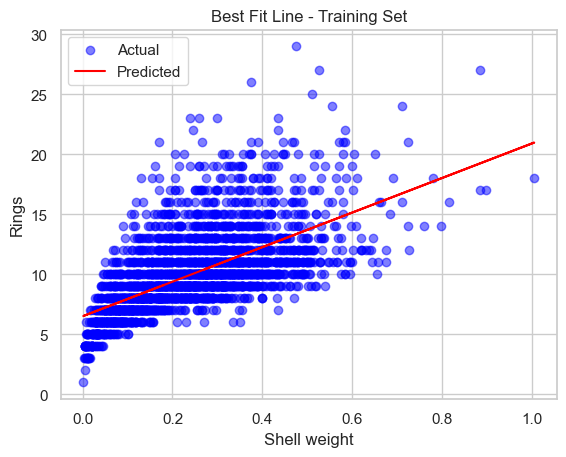

In [20]:
# Visualization of the Best Fit Line for Training Set
plt.scatter(X_train['Shell weight'], y_train, color='blue', alpha=0.5, label='Actual')  # Added alpha for transparency
plt.plot(X_train['Shell weight'], y_pred_train, color='red', label='Predicted')
plt.title("Best Fit Line - Training Set")
plt.xlabel("Shell weight")
plt.ylabel("Rings")
plt.legend()
plt.show()
# This plot shows the relationship between shell weight and rings for the training set, 
# with the actual data points in blue and the predicted regression line in red.




Die „Best Fit Line - Training Set“ Grafik veranschaulicht die Beziehung zwischen dem Gewicht der Schale und der Anzahl der Ringe bei Abalonen basierend auf den Trainingsdaten. Die tatsächlichen Datenpunkte sind in Blau dargestellt, während die rote Linie die durch das Modell vorhergesagten Werte repräsentiert. Die Passgenauigkeit dieser Linie zeigt, wie gut das Modell die Daten während der Trainingsphase approximieren kann.
Es ist eine generelle Übereinstimmung sichtbar ist, jedoch mit einiger Streuung, was auf Variabilität in den Daten hinweist.

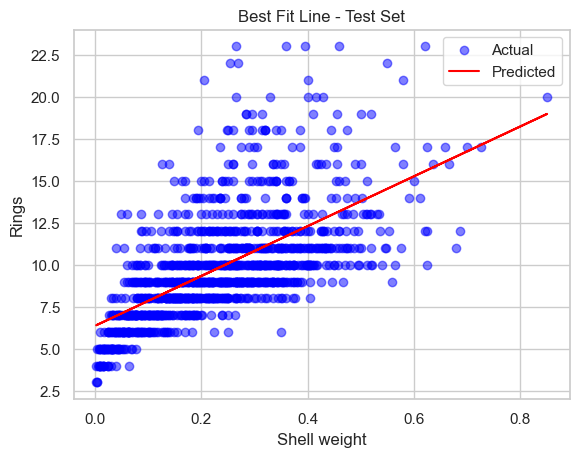

In [21]:
# Visualization of the Best Fit Line for Test Set
plt.scatter(X_test['Shell weight'], y_test, color='blue', alpha=0.5, label='Actual')  # Added alpha for transparency
plt.plot(X_test['Shell weight'], y_pred_test, color='red', label='Predicted')
plt.title("Best Fit Line - Test Set")
plt.xlabel("Shell weight")
plt.ylabel("Rings")
plt.legend()
plt.show()
# This plot presents the relationship between shell weight and rings for the test set. 
# It also compares the actual data points and the predicted values, showcasing the model's performance.



Die Grafik zeigt die Ergebnisse der linearen Regression für das Testset, wobei die tatsächlichen Werte der Ringe wiederum als blaue Punkte und die Vorhersagen des Modells als rote Linie dargestellt werden, was auf eine gute Übereinstimmung im Testset hinweist, obwohl einige Vorhersagen die tatsächlichen Werte über- oder unterschätzen.

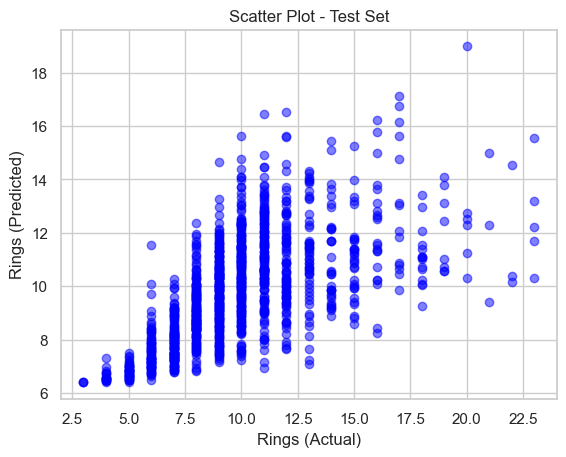

In [22]:
# Scatter Plot for Test Set Predictions
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.5)
plt.title("Scatter Plot - Test Set")
plt.xlabel("Rings (Actual)")
plt.ylabel("Rings (Predicted)")
plt.show()
# This scatter plot displays the predicted number of rings against the actual number of rings in the test set, 
# providing a visual representation of the prediction accuracy.

Im Streudiagramm für das Testset werden die tatsächlichen gegen die vorhergesagten Ringzahlen abgebildet, wobei eine enge Punktwolke um die Diagonale auf eine allgemein gute Vorhersagegenauigkeit hinweist, auch wenn sichtbare Abweichungen besonders bei höheren Ringzahlen eine Präzisierung des Modells nahelegen.

### Multivariate lineare Regression: Integration aller Merkmale in das Modell zur Steigerung der Vorhersagegenauigkeit.



Die multivariate lineare Regression erlaubt es, die Beziehungen zwischen mehreren unabhängigen Variablen und der abhängigen Variable gleichzeitig zu betrachten. Im Gegensatz zu einem einfachen linearen Modell, das nur eine Variable betrachtet, kann ein multivariates Modell zeigen, wie verschiedene Merkmale gemeinsam das Ergebnis beeinflussen. In diesem Kontext, wo mehrere physikalische Messungen der Abalones vorliegen, ermöglicht die multivariate Regression eine umfassendere Analyse. Sie kann aufdecken, wie unterschiedliche Merkmale zusammenwirken, um das Alter der Abalones genauer vorherzusagen, und bietet somit potenziell eine höhere Vorhersagegenauigkeit, da sie die kombinierte Wirkung aller Merkmale auf die Zielvariable berücksichtigt.

In [23]:
def multiple_fit(X, y):
    # Initialize the Linear Regression model
    regressor = LinearRegression()
    # Fit the model with the training data
    regressor.fit(X, y)
    # Make predictions using the fitted model
    pred = regressor.predict(X)
    return pred

# Make predictions for both training and test data using X_train, X_test
y_pred_train = multiple_fit(X_train, y_train)
y_pred_test = multiple_fit(X_test, y_test) 

In [24]:
# Calculate the Root Mean Squared Error (RMSE) for training and test data
multiple_error_train = sqrt(mean_squared_error(y_train, y_pred_train))
multiple_error_test = sqrt(mean_squared_error(y_test, y_pred_test))
print("RMSE Error for Multiple Regression, Train data is: %.2f" % multiple_error_train)
print("RMSE Error for Multiple Regression, Test data is: %.2f" % multiple_error_test)

RMSE Error for Multiple Regression, Train data is: 2.22
RMSE Error for Multiple Regression, Test data is: 2.21



Das multivariate Modell erzielt mit 2,22 Ringen RMSE für das Training und 2,21 für das Testen eine hohe Konsistenz und zeigt, dass mehr Variablen die Genauigkeit steigern.

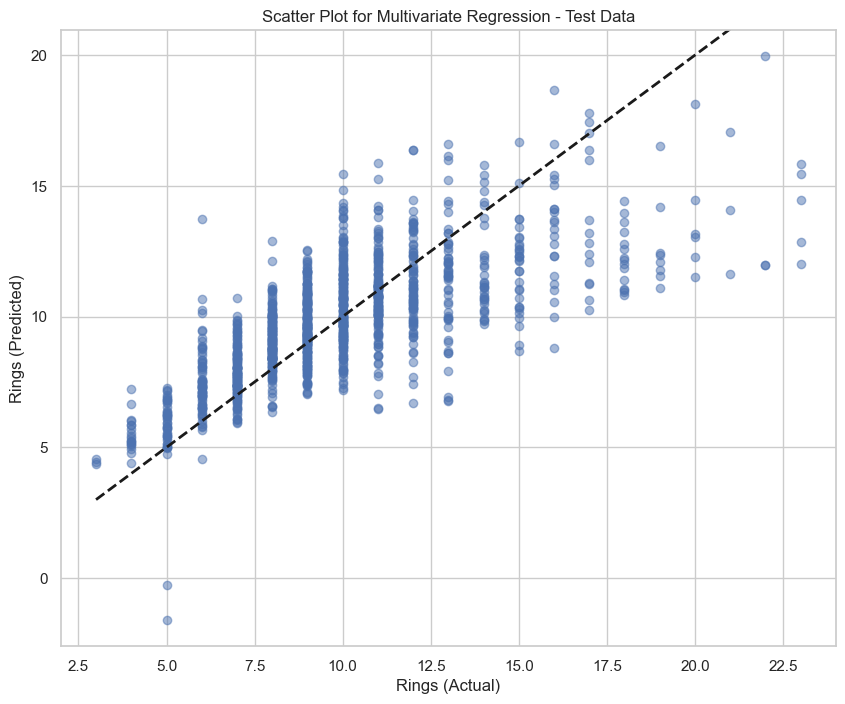

In [25]:
# Visualizing the scatter plot for multivariate regression on test data
plt.figure(figsize=(10, 8))
# Adding alpha transparency to the scatter plot
plt.scatter(y_test, y_pred_test, alpha=0.5)
# Adding a reference line to the plot for better comparison
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
# Setting axis limits for clarity
plt.xlim(y_test.min()-1, y_test.max()+1)
plt.ylim(y_pred_test.min()-1, y_pred_test.max()+1)
plt.title("Scatter Plot for Multivariate Regression - Test Data")
plt.xlabel("Rings (Actual)")
plt.ylabel("Rings (Predicted)")
plt.grid(True)
plt.show()


In diesem Streudiagramm für die multivariate Regression mit Testdaten scheinen die vorhergesagten Ringe im Allgemeinen mit den tatsächlichen Ringen zu korrelieren, was auf eine zufriedenstellende Modellleistung hindeutet. Die Datenpunkte folgen der gestrichelten Linie, die die ideale Übereinstimmung darstellt, recht gut, aber mit zunehmender Anzahl von Ringen erhöht sich die Streuung der Punkte, was möglicherweise auf eine höhere Vorhersageunsicherheit oder Modellüberanpassung (Overfitting) bei diesen Daten hinweist. Der bemerkte Punkt bei ungefähr 5.0 echten Ringen, der eine niedrigere vorhergesagte Anzahl von Ringen zu haben scheint, könnte ein Ausreißer sein oder aus einer Inkonsistenz im Modell resultieren, insbesondere wenn das Modell in Bereichen mit wenigen Datenpunkten zu optimistisch oder pessimistisch ist.

### Nichtlineare Regression: Einsatz polynomialer Funktionen und Bestimmung des optimalen Grades durch Hyperparametrisierung.


Eine nichtlineare Regression kann sinnvoll sein, weil sie die Möglichkeit bietet, komplexe Beziehungen zwischen den Merkmalen und der Zielvariable zu modellieren, die über die lineare Annäherung hinausgehen. Insbesondere bei Datensätzen, bei denen die Beziehung zwischen den Eingangsvariablen und der Zielvariable nicht linear ist oder wenn es Hinweise auf Interaktionen oder quadratische bzw. höhere Ordnungseffekte zwischen den Variablen gibt, kann ein nichtlineares Modell eine bessere Passform und genauere Vorhersagen liefern. Das Hinzufügen von Polynommerkmalen durch die Anwendung von PolynomialFeatures ermöglicht es dem linearen Modell, solche nichtlinearen Muster zu lernen und zu nutzen, was zu einer besseren Performance des Modells führen kann.

In [26]:
def predict_and_evaluate(X, y):
    # Define polynomial degrees to evaluate
    degrees = [2, 3, 4, 5]
    errors = []  # To store RMSE values for each degree
    predictions_dict = {}  # To store predictions for each degree

    # Iterate over each degree, fit the model, and calculate predictions and RMSE
    for degree in degrees:
        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree)
        X_poly = poly_features.fit_transform(X)
        
        # Fit Linear Regression model
        model = LinearRegression()
        model.fit(X_poly, y)
        
        # Make predictions using the model
        predictions = model.predict(X_poly)
        
        # Calculate RMSE and store it
        rmse = sqrt(mean_squared_error(y, predictions))
        errors.append(rmse)
        predictions_dict[degree] = predictions
    
    return errors, predictions_dict



Die folgende Grafik zeigt den RMSE (Root Mean Square Error) für Polynomregressionsmodelle unterschiedlicher Grade, angewendet auf Trainings- und Testdatensätze

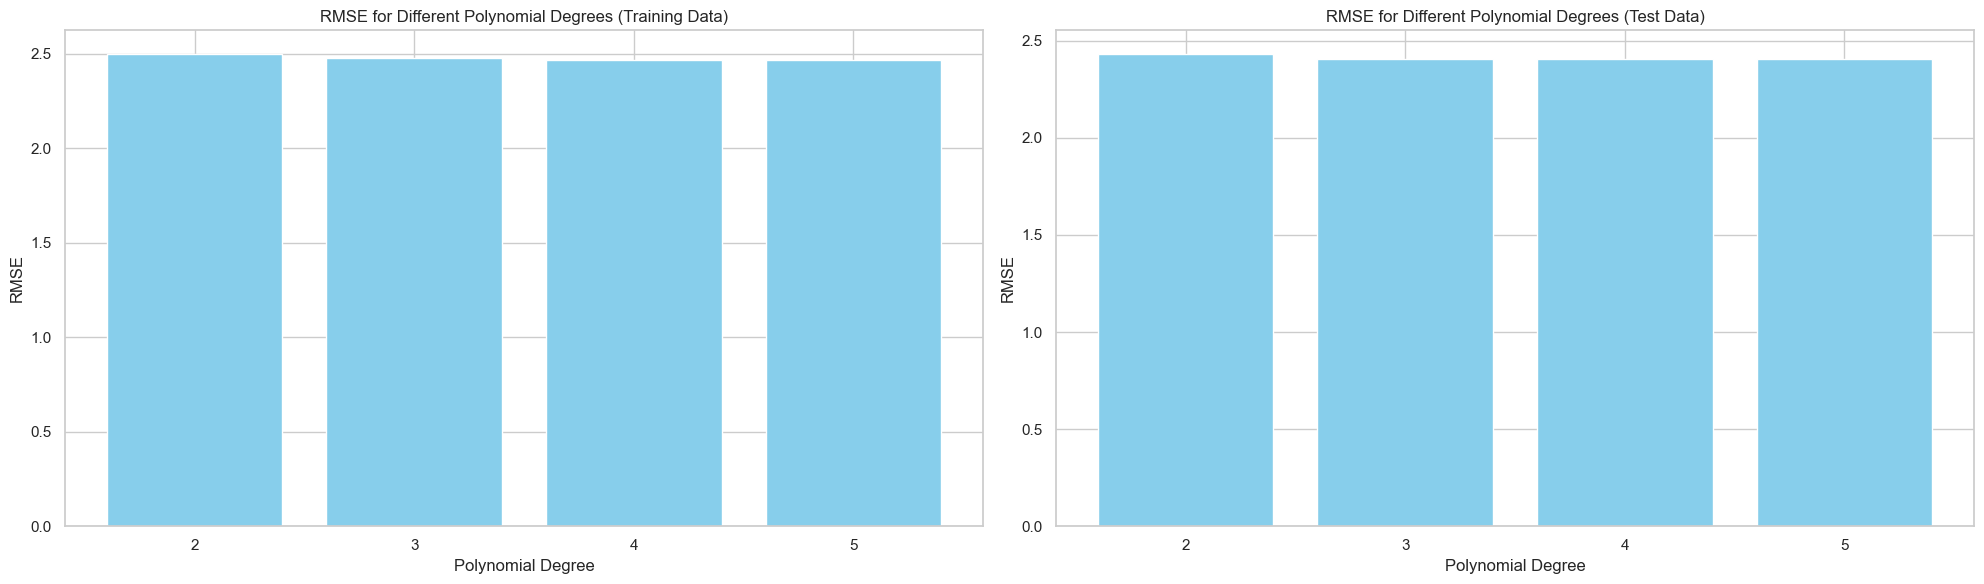

In [27]:
# Calculate RMSE for different polynomial degrees
errors_train, predictions_train_dict = predict_and_evaluate(X_train[['Shell weight']], y_train)
errors_test, predictions_test_dict = predict_and_evaluate(X_test[['Shell weight']], y_test)


# Function to plot RMSE against polynomial degree
def plot_rmse(degrees, errors, dataset_label, ax):
    ax.bar(degrees, errors, color='skyblue')
    ax.set_xlabel('Polynomial Degree')
    ax.set_ylabel('RMSE')
    ax.set_title(f'RMSE for Different Polynomial Degrees ({dataset_label})')
    ax.set_xticks(degrees)

# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot RMSE for training data on the first subplot
plot_rmse([2, 3, 4, 5], errors_train, 'Training Data', ax1)

# Plot RMSE for test data on the second subplot
plot_rmse([2, 3, 4, 5], errors_test, 'Test Data', ax2)

# Display the plots
plt.tight_layout()
plt.show()



Die fast identische Höhe der Balken für die Polynomgrade von 2 bis 5 deutet darauf hin, dass eine Erhöhung des Polynomgrads den RMSE nicht signifikant verringert. Dies lässt darauf schließen, dass ein komplexeres Modell nicht unbedingt zu einer besseren Anpassung an diese Daten führt. Das könnte bedeuten, dass für diesen speziellen Datensatz ein Polynom zweiten Grades genauso effektiv ist wie höhere Grade, um die Beziehung zwischen Schalengewicht und Ringanzahl zu erfassen, und daher möglicherweise komplexere Modelle nicht notwendig sind.

______________________________

In diesem Scatterplot wird die Beziehung zwischen dem Schalengewicht und der Anzahl der Ringe von Abalonen illustriert.

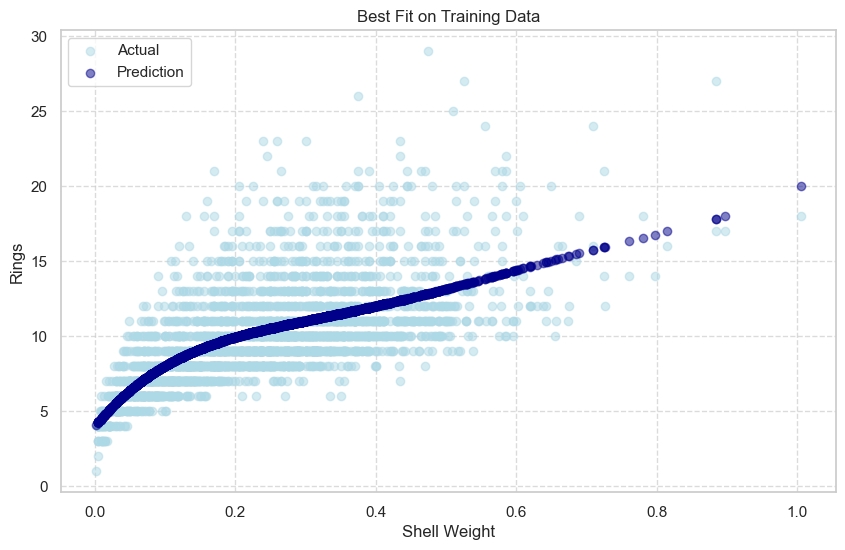

In [28]:
# Plotting the best fit on training data
best_degree = np.argmin(errors_train) + 2  # Determine the degree with the lowest RMSE
plt.figure(figsize=(10, 6))
plt.scatter(X_train['Shell weight'], y_train, color='lightblue', label='Actual', alpha=0.5)
plt.scatter(X_train['Shell weight'], predictions_train_dict[best_degree], color='darkblue', label='Prediction', alpha=0.5)
plt.legend()
plt.xlabel('Shell Weight')
plt.ylabel('Rings')
plt.title('Best Fit on Training Data')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Die durchsichtigen hellblauen Punkte repräsentieren die tatsächlichen Daten des Trainingssets, während die dunkelblauen Punkte die Vorhersagen des Modells darstellen. Die breite Streuung der Vorhersagepunkte um die tatsächlichen Werte, besonders im Bereich der niedrigeren Ringzahlen, zeigt, dass das Modell in diesem Segment relativ gut abschneidet. Doch die Punkte, die vom dichten Cluster abweichen, insbesondere bei höheren Ringzahlen, deuten auf Ungenauigkeiten hin, was auf Überanpassung (Overfitting) oder Varianz im Modell hindeuten könnte. Diese Visualisierung hilft dabei, Bereiche zu identifizieren, in denen das Modell möglicherweise angepasst werden muss, um die Genauigkeit der Vorhersagen zu verbessern.

_______________________________________________________________

Dieser Scatterplot vergleicht die tatsächlichen mit den vorhergesagten Ringzahlen der Abalone-Schalen auf dem Testdatensatz.

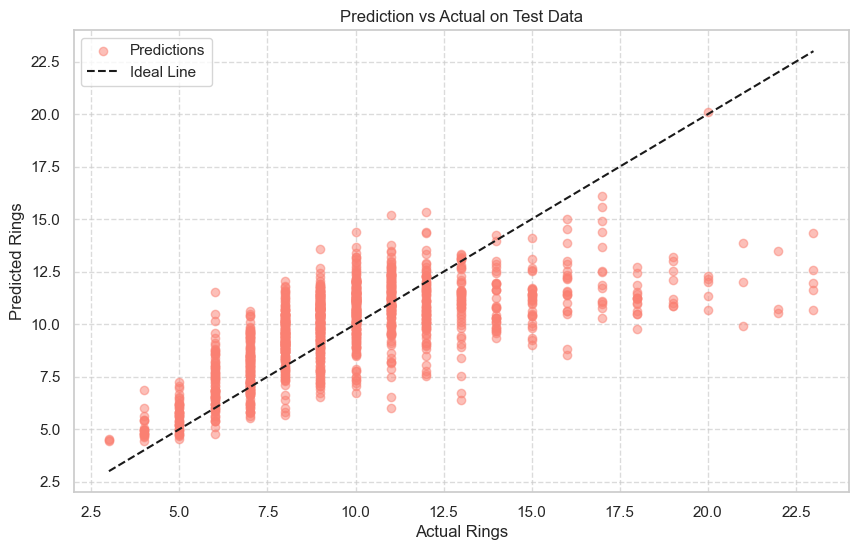

In [29]:
# Plotting predicted vs actual rings on test data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions_test_dict[best_degree], color='salmon', alpha=0.5, label='Predictions')
plt.xlabel('Actual Rings')
plt.ylabel('Predicted Rings')
plt.title('Prediction vs Actual on Test Data')
# Ideal line for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Ideal Line')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


 Die salmonfarbenen Punkte repräsentieren die Vorhersagen des Modells. Je näher die Punkte an der gestrichelten Ideal-Linie liegen, desto genauer sind die Vorhersagen. Es zeigt sich, dass viele Vorhersagen ziemlich nahe an der Linie sind, was auf eine gute Übereinstimmung hindeutet, insbesondere im mittleren Bereich der Ringzahlen. Allerdings gibt es auch einige Vorhersagen, die weiter entfernt sind, was auf größere Abweichungen und potenzielle Ungenauigkeiten des Modells hinweist, besonders bei hohen Ringzahlen.

### Multivariate nichtlineare Regression: Kombination aller Merkmale und Auswahl des optimalen Polynomgrades zur Verfeinerung der Vorhersagen.


Eine multivariate nichtlineare Regression, die alle Merkmale kombiniert und den optimalen Polynomgrad auswählt, könnte sinnvoll sein, um die Komplexität und die nichtlinearen Zusammenhänge in den Daten besser abzubilden. Während lineare Modelle nur lineare Beziehungen erfassen, kann ein nichtlineares Modell eine größere Bandbreite an Mustern erkennen, wie etwa kurvige Trends und Wechselwirkungen zwischen den Merkmalen, die bei biologischen Daten wie bei Abalones häufig auftreten. Der optimale Polynomgrad hilft dabei, das Modell genau genug zu machen, um subtile Muster zu erkennen, ohne zu überanpassen. Dieser Ansatz kann vor allem dann von Vorteil sein, wenn die Beziehung zwischen den Prädiktoren und der Zielvariablen komplex ist und durch lineare Terme nicht vollständig erfasst wird.


Die folgende Funktion führt eine multivariate nichtlineare Regression mit verschiedenen Polynomgraden durch, um die Beziehung zwischen Features und Zielvariablen zu modellieren. Sie evaluiert jedes Modell anhand des RMSE, der die Vorhersagegenauigkeit misst, und sucht den Polynomgrad, der die genauesten Ergebnisse liefert. Zielvariablen werden aus den Features entfernt, um eine unverzerrte Modellierung zu gewährleisten.

In [30]:
def poly_regression_analysis(X, y, degrees=[2, 3, 4, 5]):
    error_list = []  # To store RMSE for each polynomial degree
    predictions_dict = {}  # To store predictions for each degree
    
    # Loop through each specified degree, create polynomial features, and fit a regression model
    for degree in degrees:
        poly_feat_maker = PolynomialFeatures(degree=degree)  # Create polynomial features
        X_poly = poly_feat_maker.fit_transform(X)  # Transform the features
        poly_regressor = LinearRegression()  # Initialize the regressor
        poly_regressor.fit(X_poly, y)  # Fit the model
        predictions = poly_regressor.predict(X_poly)  # Predict the target variable
        
        # Calculate and store the RMSE for the current degree
        model_rmse = sqrt(mean_squared_error(y, predictions))
        error_list.append(model_rmse)
        predictions_dict[degree] = predictions

    return error_list, predictions_dict

# Removing 'Rings' column if present to avoid using the target variable as a feature
X_train_adjusted = X_train.drop(columns='Rings', errors='ignore')
X_test_adjusted = X_test.drop(columns='Rings', errors='ignore')

# Performing regression and making predictions
train_errors, train_predictions_dict = poly_regression_analysis(X_train_adjusted, y_train, degrees=[2, 3, 4, 5])
test_errors, test_predictions_dict = poly_regression_analysis(X_test_adjusted, y_test, degrees=[2, 3, 4, 5])





Jetzt erfolgt die Berechnung des RMSE für Polynome zweiten bis fünften Grades, sowohl für die Trainings- als auch für die Testdaten.

In [31]:
# Output the RMSE values for the training data
print("Training data RMSE:")
for degree, rmse in zip([2, 3, 4, 5], train_errors):
    print(f"Degree {degree}, RMSE: {rmse:.2f}")

# Output the RMSE values for the test data
print("\nTest data RMSE:")
for degree, rmse in zip([2, 3, 4, 5], test_errors):
    print(f"Degree {degree}, RMSE: {rmse:.2f}")

Training data RMSE:
Degree 2, RMSE: 2.08
Degree 3, RMSE: 1.99
Degree 4, RMSE: 1.84
Degree 5, RMSE: 1.58

Test data RMSE:
Degree 2, RMSE: 2.05
Degree 3, RMSE: 1.93
Degree 4, RMSE: 1.60
Degree 5, RMSE: 1.01


Die Ergebnisse zeigen, dass die Genauigkeit der Modellvorhersagen mit steigendem Polynomgrad zunimmt, was durch die sinkenden RMSE-Werte für das Training und die Testdaten angezeigt wird. Besonders auffällig ist der signifikante Rückgang des RMSE auf 1.01 im Testdatensatz für das Polynom fünften Grades, was auf eine hohe Anpassungsfähigkeit des Modells an komplexe Muster in den Daten hinweist. 

__________________________________________________________________________________________________________________________________________________________________________________________________________________


Der Code zeigt eine Grafik, in der die tatsächlichen und vorhergesagten Ringe der Abalonen basierend auf dem Gewicht der Schale verglichen werden, wobei das Polynom mit dem geringsten Fehler verwendet wird (degree=5). Grüne Punkte stehen für echte Messwerte, rote für die Vorhersagen des Modells.

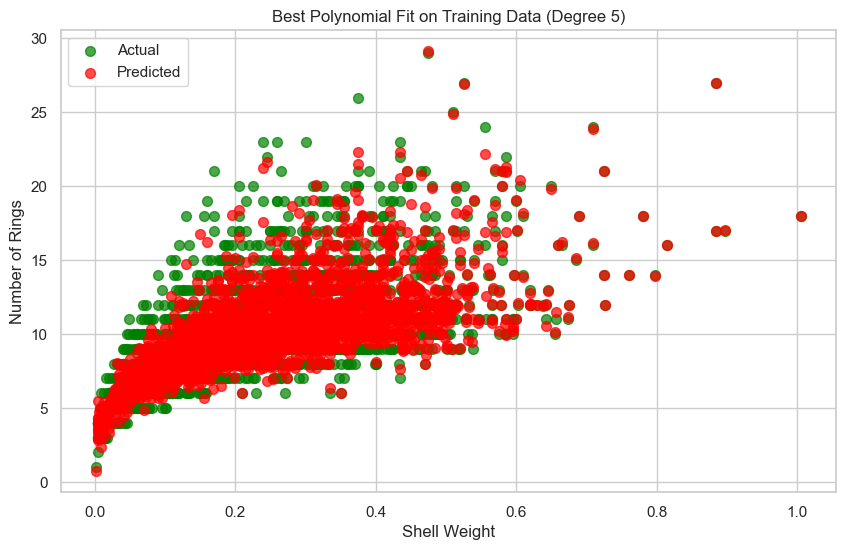

In [32]:

# Visualizing the best polynomial fit on training data
best_degree = np.argmin(train_errors) + 2  # Determine the degree with the lowest RMSE
plt.figure(figsize=(10, 6))
# Plot actual vs predicted values with custom styling
plt.scatter(X_train_adjusted['Shell weight'], y_train, color='green', alpha=0.7, s=50, label='Actual')
plt.scatter(X_train_adjusted['Shell weight'], train_predictions_dict[best_degree], color='red', alpha=0.7, s=50, label='Predicted')
plt.title(f'Best Polynomial Fit on Training Data (Degree {best_degree})')
plt.xlabel('Shell Weight')
plt.ylabel('Number of Rings')
plt.legend()
plt.show()


Auf dem Bild sehen wir, dass das Modell bei geringen und mittleren Schalen-Gewichten tatsächlich ziemlich nahe an den tatsächlichen Ringanzahlen zu sein scheint, da die roten und grünen Punkte oft übereinstimmen. Jedoch bei den höheren Schalen-Gewichten streuen die Vorhersagen weiter um die tatsächlichen Werte, was auf eine größere Unsicherheit oder eine höhere Variabilität des Modells in diesem Bereich hindeutet.

________________________________________________________________________________

In diesem Scatter-Plot werden die tatsächlichen Werte der Zielvariablen (Anzahl der Ringe) gegen die vorhergesagten Werte mit dem besten Polynomgrad (5) dargestellt. 

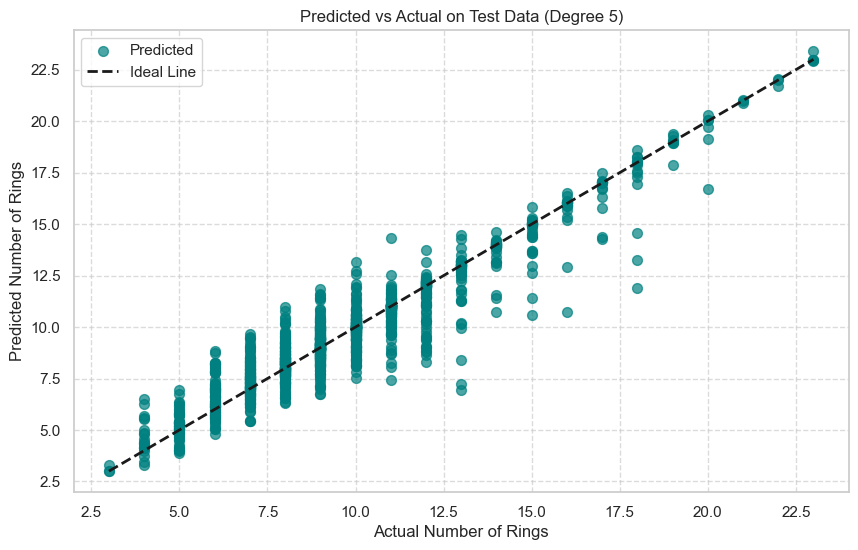

In [33]:

# Scatter plot of actual vs predicted rings on test data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions_dict[best_degree], color='teal', alpha=0.7, s=50, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Line')
plt.title(f'Predicted vs Actual on Test Data (Degree {best_degree})')
plt.xlabel('Actual Number of Rings')
plt.ylabel('Predicted Number of Rings')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In diesem Scatter-Plot ist eine starke Korrelation zwischen den vorhergesagten und den tatsächlichen Werten zu beobachten, wobei die Datenpunkte um die ideale Linie herum tendieren, was auf eine gute Modellpassung hinweist. Bei einer niedrigen Anzahl von Ringen zeigt das Modell jedoch Tendenzen, die Werte zu unterschätzen, während es bei einer höheren Anzahl von Ringen eine genauere Vorhersage liefert. Die enge Streuung der Punkte nahe der idealen Linie deutet auf eine hohe Vorhersagegenauigkeit hin, wobei einige wenige Ausreißer, insbesondere im Bereich von niedrigeren Ringzahlen, auf mögliche Anomalien oder Modellabweichungen hinweisen könnten.

## Modellspeicherung und -anwendung



Speicherung des Modells für zukünftige Vorhersagen und Anwendungen auf neue Datensätze.

In [49]:
# Ignore UserWarnings issued by scikit-learn
warnings.filterwarnings('ignore', category=UserWarning)

# Initialize the encoder with handle_unknown='ignore' to handle any unknown categories during transformation
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Fit the encoder on the 'Sex' column of the entire dataset
encoder.fit(df[['Sex']])

# Transform your test example
test_example = pd.DataFrame([{'Sex': 'M'}])
test_encoded = encoder.transform(test_example[['Sex']])

# Add the remaining features
test_features = np.array([0.350, 0.265, 0.090, 0.2255, 0.0995, 0.0485, 0.070]).reshape(1, -1)

# Combine the One-Hot-encoded features with the remaining features
full_test_example = np.concatenate([test_encoded, test_features], axis=1)

# Save the model to disk
pickle.dump(regressor, open('reg_model.pkl','wb'))

# Load the model and make a prediction
model = pickle.load(open('reg_model.pkl', 'rb'))
print(model.predict(full_test_example))


[5.6503166]



Dieser Code unterdrückt Warnmeldungen, kodiert das Merkmal 'Sex' eines Testbeispiels mit OneHotEncoder, kombiniert es mit anderen Merkmalen, speichert ein trainiertes Regressionsmodell und macht dann Vorhersagen auf neuen Daten.

## Schlussfolgerung


Nach einer gründlichen Untersuchung und Analyse des Abalone-Datensatzes, der auf verschiedenen Ebenen der Datenverarbeitung und Modellierung durchgeführt wurde, können wir einige wichtige Erkenntnisse festhalten.

Der Datensatz wurde sorgfältig auf fehlende Werte und Duplikate überprüft, was eine robuste Grundlage für die weiteren Analyseschritte bildete. Die explorative Datenanalyse zeigte auf, dass die Zielvariable "Rings", die das Alter der Abalone repräsentiert, eine breite Streuung aufweist und damit eine Herausforderung für die präzise Vorhersage darstellt.

Bei der Datenvorbereitung wurde das kategoriale Merkmal "Geschlecht" erfolgreich in ein Set binärer Variablen transformiert, was eine sinnvolle Einbeziehung dieser Daten in die Regressionsmodelle ermöglichte. Zudem wurde die Korrelationsanalyse genutzt, um die Zusammenhänge zwischen den Features zu verstehen, wobei insbesondere das Merkmal "Shell weight" eine signifikante Korrelation mit dem Alter zeigte.

In der Modellierungsphase wurden verschiedene Ansätze, von der linearen über die multivariate lineare bis hin zur nichtlinearen und multivariaten nichtlinearen Regression, angewendet und bewertet. Dabei wurde klar, dass die Einbeziehung aller verfügbaren Merkmale in das Modell sowie die Anpassung an nichtlineare Zusammenhänge zur Steigerung der Vorhersagegenauigkeit beitragen.

Die Vorhersagekraft der Modelle wurde hauptsächlich mittels RMSE bewertet, einer Metrik, die empfindlich auf größere Fehler reagiert und somit ein realistisches Bild der Modellleistung gibt. Es wurde festgestellt, dass die komplexeren Modelle tendenziell bessere Vorhersagen lieferten, was darauf hindeutet, dass die Beziehungen im Datensatz nicht ausschließlich linear sind.

Abschließend zeigte der letzte Schritt der Modellanalyse, dass die multivariate nichtlineare Regression die Fähigkeit des Modells, die Beziehung zwischen den verschiedenen Merkmalen und der Zielvariablen präziser abzubilden, weiter verbessert. Dabei wurde deutlich, dass die Wahl des Modells und des Polynomgrades einen erheblichen Einfluss auf die Vorhersagegenauigkeit hat.

Zusammenfassend lässt sich sagen, dass der gesamte Analyseprozess wertvolle Einblicke in die Beziehung zwischen den physischen Merkmalen von Abalonen und ihrem Alter bietet und leistungsstarke Vorhersagemodelle hervorgebracht hat. Diese Modelle können als zuverlässiges Werkzeug dienen, um das Alter von Abalonen basierend auf einfach zu messenden physischen Eigenschaften zu schätzen, und bieten potenziell nützliche Anwendungen in Bereichen wie der nachhaltigen Fischerei und der Meeresbiologie.






